## **Auckland’s Smart City Traffic Optimization**
**Goal:** **Analyze and optimize Auckland's traffic using historical congestion and weather data to inform better city planning and traffic management decisions.**

Author: Haru

Date: 16 April 2025

**Introduction**

This project focuses on leveraging smart technologies—such as IoT sensors, AI-driven analytics, and real-time data processing—to optimize traffic flow across Auckland’s urban network. 
By analyzing congestion patterns and public transport efficiency, the system aims to reduce delays and improve commute times.

We chose this project because Auckland’s growing population and increasing traffic congestion demand innovative solutions. 
Smart traffic management can enhance sustainability, economic productivity, and quality of life for residents while aligning with global smart city trends.

The pobjective is to create a dynamic, data-driven traffic system that adapts in real time, prioritizing high demand routes and integrating multi-modal transportion options.

If successful, this project could significantly cut travel times, reduce fuel consumption, and set a benchmark for other cities pursuing smart urban mobility.



## **1. Data Collection**

**Data Sources**:
- NZTA Traffic Count Dataset
- Open-Meteo API for 2024 Rainfall Data

In [7]:
!pip install requests
!pip install pandas


import requests
import pandas as pd

**1-1.Download NZTA Traffic Counts**

In [34]:
traffic_counts = pd.read_csv(r"D:\Tabular1\TMS_Telemetry_Sites_4135033762041494366.csv")

**1-2.Download Open-Meteo API for 2024 Rainfall Data**

In [36]:
url = "https://archive-api.open-meteo.com/v1/archive?latitude=36.8485&longitude=174.7633&start_date=2024-01-01&end_date=2024-12-31&hourly=precipitation&timezone=Pacific%2FAuckland"


response = requests.get(url)
weather_data_2024 = response.json()

# Convert to DataFrame
weather_df_2024 = pd.DataFrame({
    "datetime": weather_data_2024["hourly"]["time"],
    "rainfall_mm": weather_data_2024["hourly"]["precipitation"]
})

## **2.Data Exploration (EDA)**

**In this section, we explore the structure, content, and quality of the two datasets:**

- Historical Traffic Count Data

- Hourly Weather (Rainfall) Data

Let's have a look at the data using df.head function.

#### **2-1.Traffic Counts Data**

This historical dataset covers 6.3 million rows of vehicle count data across New Zealand roads by hour, direction, and vehicle class.

##### **Key Columns**:
Start Date: Timestamp

Region Name, Site Description: Location

Traffic Count: Hourly vehicle volume

In [42]:
traffic_counts.head()

,OBJECTID,Start Date,Site Alias,Region Name,Site Reference,Class Weight,Site Description,Lane Number,Flow Direction,Traffic Count
0,1,12/31/2017 12:00:00 PM,39,05 - Gisborne,00200444,Light,200 m Nth of Bell Rd,2,2,2468.0
1,2,12/31/2017 12:00:00 PM,39,05 - Gisborne,00200444,Heavy,200 m Nth of Bell Rd,2,2,73.0
2,3,12/31/2017 12:00:00 PM,39,05 - Gisborne,00200444,Heavy,200 m Nth of Bell Rd,1,1,74.0
3,4,12/31/2017 12:00:00 PM,39,05 - Gisborne,00200444,Light,200 m Nth of Bell Rd,1,1,3806.0
4,5,12/31/2017 12:00:00 PM,40,05 - Gisborne,00200448,Heavy,Sth end of Whatatuna Bridge,1,1,58.5


In [43]:
traffic_counts.shape

(6336019, 10)

**Observations:**
Wide regional and temporal coverage

Needs datetime formatting: pd.to_datetime()

Need to extract data for the Auckland area.

Time of Start Date is only 12PM/12AM, We need to assign time cluster by Kmeans cluster.


#### **2-2.Weather Data (Rainfall)**

This dataset contains hourly rainfall data over several months in 2024.

 #### Columns:
datetime: ISO timestamp

rainfall_mm: Rainfall amount in millimeters

In [47]:
weather_df_2024.head()

,datetime,rainfall_mm
0,2024-01-01T00:00,0.7
1,2024-01-01T01:00,1.9
2,2024-01-01T02:00,0.4
3,2024-01-01T03:00,0.1
4,2024-01-01T04:00,0.1


In [48]:
weather_df_2024.shape

(8784, 2)

**Observations:**

There are many NaN values — possibly missing data from the source.

Imputation or row removal needed for modeling.

8784 hourly records ≈ 12 months


#### **2-3. Null Values & Duplicates**

In [83]:
traffic_counts.isnull().sum()

OBJECTID            0
Start Date          0
Site Alias          0
Region Name         0
Site Reference      0
Class Weight        0
Site Description    0
Lane Number         0
Flow Direction      0
Traffic Count       0
dtype: int64

In [84]:
traffic_counts.duplicated().sum()

0

In [85]:
weather_df_2024.isnull().sum()

datetime       0
rainfall_mm    0
dtype: int64

In [86]:
weather_df_2024.duplicated().sum()

0

The results show that these data sets do not have any null value.

#### **2-4. Potential Merges**

- Merge Traffic Counts and Weather by matching daystamp (after converting to datetime)
- To merge, we need to extract year 2024 from Traffic Counts Data
- To merge, we need to make daily data by aggregating Weather Data

#### **2-5. Summary Statistics of Traffic Count**
Mean Traffic Count: ~3,000 vehicles

Max: 20,000+, Min: ~0

High variability suggests peak-hour traffic and event-based congestion.

#### **2-6. To better understand the patterns in the data, the following visualizations will be explored:**
- Average Traffic Count by month
- Total Traffic Count by Weekday
- Traffic Count Distribution by Time Cluster(Hourly Peaks)

##### *Weather Impact*
 - Relationship between Rainfall and Traffic Count in 2024
 - Traffic Count by Rainfall Level (2024)
##### *Routes recommendation*
- Most Congested Road Segments in Auckland
- Fasest Road Segments in Auckland

These visual insights will help identify patterns and support model-building in later stages.

## **3.Data Cleaning & Preprocessing**

#### **3-1 .Clean Traffic Counts Data** 

Filter for AKL regions and datetime formatting to Traffic Counts Data

In [95]:
akl_traffic1 = traffic_counts[traffic_counts['Region Name']=='02 - Auckland']
#Make datetime style
akl_traffic1 = akl_traffic1.copy()
akl_traffic1['datetime'] = pd.to_datetime(akl_traffic1['Start Date'])
print(akl_traffic1.head())

     OBJECTID              Start Date  Site Alias    Region Name  \
204       205  12/31/2017 12:00:00 PM         334  02 - Auckland   
205       206  12/31/2017 12:00:00 PM         334  02 - Auckland   
206       207  12/31/2017 12:00:00 PM         334  02 - Auckland   
207       208  12/31/2017 12:00:00 PM         334  02 - Auckland   
208       209  12/31/2017 12:00:00 PM         340  02 - Auckland   

    Site Reference Class Weight  \
204       01600024        Heavy   
205       01600024        Heavy   
206       01600024        Light   
207       01600024        Light   
208       01600058        Light   

                                      Site Description  Lane Number  \
204          SH16 Nth of Coatesville Riverhead Highway            1   
205          SH16 Nth of Coatesville Riverhead Highway            2   
206          SH16 Nth of Coatesville Riverhead Highway            1   
207          SH16 Nth of Coatesville Riverhead Highway            2   
208  SH16 Nth of Kahikate

### 4.Feature Engineering 

##### **4-1. Make a Monthly Average Traffic Count data** 

Extracted and aggregated hourly traffic data to analyze average traffic volume by calendar month across years.
- Parsed datetime to extract both full "YYYY-MM" and numeric month.
- Calculated monthly average traffic counts to identify seasonal trends.
- Result Insight: Traffic peaks in March and November, while January sees the lowest activity, likely due to holiday periods and school breaks.

This analysis helps highlight predictable congestion trends and informs traffic planning or public transport adjustments.

In [98]:
#Monthly Traffic Data
akl_traffic1_with_month = akl_traffic1.copy()
akl_traffic1_with_month["datetime"] = pd.to_datetime(akl_traffic1["datetime"])
akl_traffic1_with_month["month"] = akl_traffic1_with_month["datetime"].dt.to_period("M").astype(str)
monthly_traffic= akl_traffic1_with_month.groupby("month")["Traffic Count"].mean().reset_index()

#Monthly Average Traffic Data
akl_traffic1_with_month["month_num"] = akl_traffic1_with_month["datetime"].dt.month
monthly_avg = akl_traffic1_with_month.groupby("month_num")["Traffic Count"].mean().reset_index()
monthly_avg = monthly_avg.sort_values("month_num")

print(monthly_avg)

    month_num  Traffic Count
0           1    7376.819296
1           2    7606.366216
2           3    7558.988083
3           4    6803.657090
4           5    7387.937842
5           6    7350.197223
6           7    7561.268749
7           8    6873.989759
8           9    6953.890099
9          10    7470.980847
10         11    7729.305426
11         12    7567.684463


##### **4-2. Make a data showing the total and average traffic volume for each day of the week**

Analyzed traffic patterns by day of the week using datetime features from NZTA hourly traffic data.
- Extracted weekday names from timestamps.
- Calculated total and average traffic volume per day.
- Sorted days in natural order (Monday to Sunday) for better readability.

In [100]:
akl_traffic1['datetime'] = pd.to_datetime(akl_traffic1['datetime'])
akl_traffic1['weekday'] = akl_traffic1['datetime'].dt.day_name()

weekday_summary = akl_traffic1.groupby('weekday')['Traffic Count'].agg(['sum','mean']).reset_index()
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_summary['weekday'] = pd.Categorical(weekday_summary['weekday'], categories=weekday_order, ordered=True)

weekday_summary = weekday_summary.sort_values('weekday')

print(weekday_summary)

     weekday           sum         mean
1     Monday  1.933036e+09  7361.056462
5    Tuesday  2.020967e+09  7670.490005
6  Wednesday  2.079683e+09  7880.753124
4   Thursday  2.102379e+09  7999.403931
0     Friday  1.996604e+09  7587.150006
2   Saturday  1.708983e+09  6506.571145
3     Sunday  1.706983e+09  6504.154044


##### **4-3. Segment traffic data into four distinct groups based on traffic volume using K-Means clustering (for later merging with weather data).**

We applied the K-means clustering algorithm to segment time intervals into four distinct groups based on traffic volume patterns:

- Morning Rush(6am-9am)
- Day Time(10pm-3pm)
- Evening Rush(4pm-7pm)
- Night to Morning(8pm-5am)

4-3-1. Degment time intervals into four groups by K-Means

In [103]:
from sklearn.cluster import KMeans
import numpy as np

X = akl_traffic1[['Traffic Count']].values

kmeans = KMeans(n_clusters=4, random_state=42)
akl_traffic1['kmeans_cluster'] = kmeans.fit_predict(X)

print(akl_traffic1.groupby("kmeans_cluster")["Traffic Count"].mean())

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


kmeans_cluster
0     7501.539422
1    13322.804019
2     1043.717858
3    19834.596842
Name: Traffic Count, dtype: float64


 4-3-2. Assign time Based on K-Means Cluster Analysis

In [105]:
cluster_labels = {
    0: "Day Time(10am-3pm)",
    1: "Morning Rush(6am-9am)",
    2: "Night to Morning(8pm-5am)",
    3: "Evening Rush(4pm-7pm)"
}

akl_traffic1['time_label'] = akl_traffic1['kmeans_cluster'].map(cluster_labels)

akl_traffic1.head()

,OBJECTID,Start Date,Site Alias,Region Name,Site Reference,Class Weight,Site Description,Lane Number,Flow Direction,Traffic Count,datetime,weekday,kmeans_cluster,time_label
204,205,12/31/2017 12:00:00 PM,334,02 - Auckland,01600024,Heavy,SH16 Nth of Coatesville Riverhead Highway,1,1,144.5,2017-12-31 12:00:00,Sunday,2,Night to Morning(8pm-5am)
205,206,12/31/2017 12:00:00 PM,334,02 - Auckland,01600024,Heavy,SH16 Nth of Coatesville Riverhead Highway,2,2,179.0,2017-12-31 12:00:00,Sunday,2,Night to Morning(8pm-5am)
206,207,12/31/2017 12:00:00 PM,334,02 - Auckland,01600024,Light,SH16 Nth of Coatesville Riverhead Highway,1,1,8498.5,2017-12-31 12:00:00,Sunday,0,Day Time(10am-3pm)
207,208,12/31/2017 12:00:00 PM,334,02 - Auckland,01600024,Light,SH16 Nth of Coatesville Riverhead Highway,2,2,10280.0,2017-12-31 12:00:00,Sunday,0,Day Time(10am-3pm)
208,209,12/31/2017 12:00:00 PM,340,02 - Auckland,01600058,Light,SH16 Nth of Kahikatea Flat Rd (Kaukapakapa Bri...,1,1,1701.5,2017-12-31 12:00:00,Sunday,2,Night to Morning(8pm-5am)


4-3-3. Merge Traffic Count Data and Weather Data

First of all, to enable date-based merging, we consolidated both datasets into daily aggregates.

In [107]:
akl_traffic1["datetime"] = pd.to_datetime(akl_traffic1["datetime"])
akl_traffic1["date"] = akl_traffic1["datetime"].dt.date

weather_df_2024["datetime"] = pd.to_datetime(weather_df_2024["datetime"])
weather_df_2024["date"] = weather_df_2024["datetime"].dt.date

traffic_daily_1= akl_traffic1.groupby("date")["Traffic Count"].sum().reset_index()
rainny_daily_2024 = weather_df_2024.groupby("date")["rainfall_mm"].sum().reset_index()

traffic_daily_1["date"] = pd.to_datetime(traffic_daily_1["date"])
rainny_daily_2024["date"] = pd.to_datetime(rainny_daily_2024["date"])


Secondly, extract year 2024 data from traffic_daily_1 data to match with rainny_daily_2024 data.

In [108]:
traffic_2024 = traffic_daily_1[traffic_daily_1["date"].dt.year == 2024]

Finally, merge traffic_2024 data and rainny_daily_2024 data. 

In [109]:
traffic_2024 = traffic_2024.copy()
traffic_2024["date"] = pd.to_datetime(traffic_2024["date"])
rainny_daily_2024 = rainny_daily_2024.copy()
rainny_daily_2024["date"] = pd.to_datetime(rainny_daily_2024["date"])


traffic_weather = pd.merge(traffic_2024, rainny_daily_2024, on="date", how="inner")


print(traffic_weather.head())

        date  Traffic Count  rainfall_mm
0 2024-01-01      4549479.0          6.1
1 2024-01-02      4089742.0         21.9
2 2024-01-03      5343289.0          1.0
3 2024-01-04      5279048.0          0.3
4 2024-01-05      5512921.0         27.2


##### **4-4. Segment Traffic Data by Weather Conditions**

4-4-1. Grouped by Clear/Rainy day

In [112]:
traffic_weather["weather"] = traffic_weather["rainfall_mm"].apply(lambda x: "Rainy" if x > 0 else "Clear")
print(traffic_weather.head())

        date  Traffic Count  rainfall_mm weather
0 2024-01-01      4549479.0          6.1   Rainy
1 2024-01-02      4089742.0         21.9   Rainy
2 2024-01-03      5343289.0          1.0   Rainy
3 2024-01-04      5279048.0          0.3   Rainy
4 2024-01-05      5512921.0         27.2   Rainy


4-4-2. Grouped by Cloudy/Light Rain/Moderate Rain/Heavy Rain 

In [114]:
def categolize_rainfall(mm):
    if mm == 0:
        return "Clear"
    elif mm <= 2:
        return "Cloudy / Light Rain"
    elif mm <= 10:
        return "Moderate Rain"
    else:
         return "Heavy Rain"

traffic_weather["rain_level"] = traffic_weather["rainfall_mm"].apply(categolize_rainfall)

print(traffic_weather.head())

        date  Traffic Count  rainfall_mm weather           rain_level
0 2024-01-01      4549479.0          6.1   Rainy        Moderate Rain
1 2024-01-02      4089742.0         21.9   Rainy           Heavy Rain
2 2024-01-03      5343289.0          1.0   Rainy  Cloudy / Light Rain
3 2024-01-04      5279048.0          0.3   Rainy  Cloudy / Light Rain
4 2024-01-05      5512921.0         27.2   Rainy           Heavy Rain


##### **4-5. Identify Most Congested and Fastest Routes Between Key Corridors**

To determine optimal routes between high-priority origin-destination pairs (e.g., CBD to Auckland Airport), we propose the following analytical approach:

4-5-1. Filter for Roads Relevant to the Route

In [ ]:
route_related = akl_traffic1[akl_traffic1['Site Description'].str.contains('SH1|SH20|Onehunga|Airport|CBD', case=False, na=False)]

4-5-2. Group by Site and Time, get average traffic count per site, This will help identify bottlenecks (high counts = slower traffic)

In [118]:
route_grouped = route_related.groupby(['Site Description', 'Start Date'])['Traffic Count'].mean().reset_index()
segment_load= route_grouped.groupby('Site Description')['Traffic Count'].mean().sort_values()
print(segment_load)

Site Description
SH1 Beaver Rd On Ramp SB                               21.850877
SH1 Beaver Rd Off Ramp SB                              52.969697
SH1 Esmonde Rd Buslane On Ramp SB                      65.115639
SH1 Nikau Rd Off Ramp NB                              158.330808
SH1 Nikau Rd On Ramp SB                               161.796203
                                                        ...     
SH20 Coronation Rd On Ramp to Rimu Rd On Ramp NB    18289.809268
SH1 Northwestern On Ramp SB (Link 01640003)         18712.477352
SH1 Northwestern Off Ramp NB (Link 01630003)        19216.570859
SH1 Tristram Ave Interchange SB (N7)                20615.791600
SH1 Port / SH16 On Ramp NB (Link 01668002)          21463.369778
Name: Traffic Count, Length: 428, dtype: float64


fastest route" will be the one with the lowest cumulative traffic count.

### **5. Data Visualization**

#### **5-1. Which month is the most/least congested?**

**Average Traffic Count by month**

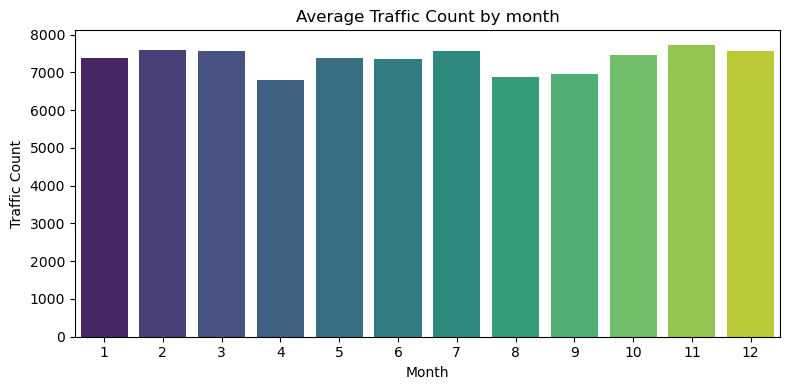

C:\Users\pc\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\pc\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


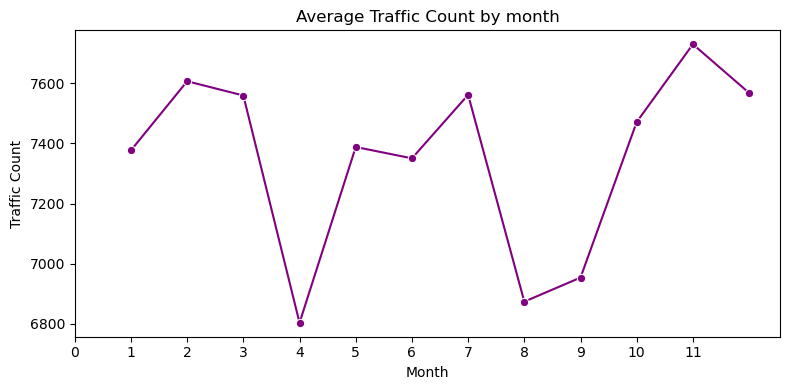

In [122]:
import matplotlib.pyplot as plt
import seaborn as sns

#Bar chart
plt.figure(figsize=(8, 4))
sns.barplot(data=monthly_avg, x="month_num", y="Traffic Count", palette="viridis")

plt.title("Average Traffic Count by month")
plt.xlabel("Month")
plt.ylabel("Traffic Count")
plt.tight_layout()
plt.show()

#line chart
plt.figure(figsize=(8, 4))
sns.lineplot(data=monthly_avg, x="month_num", y="Traffic Count", marker='o', color='purple')
plt.title("Average Traffic Count by month")
plt.xticks(ticks=range(12))
plt.xlabel("Month")
plt.ylabel("Traffic Count")
plt.tight_layout()
plt.show()

#### **5-2. Which day is the most/least congested?**

**Total Traffic Count by Weekday**

C:\Users\pc\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


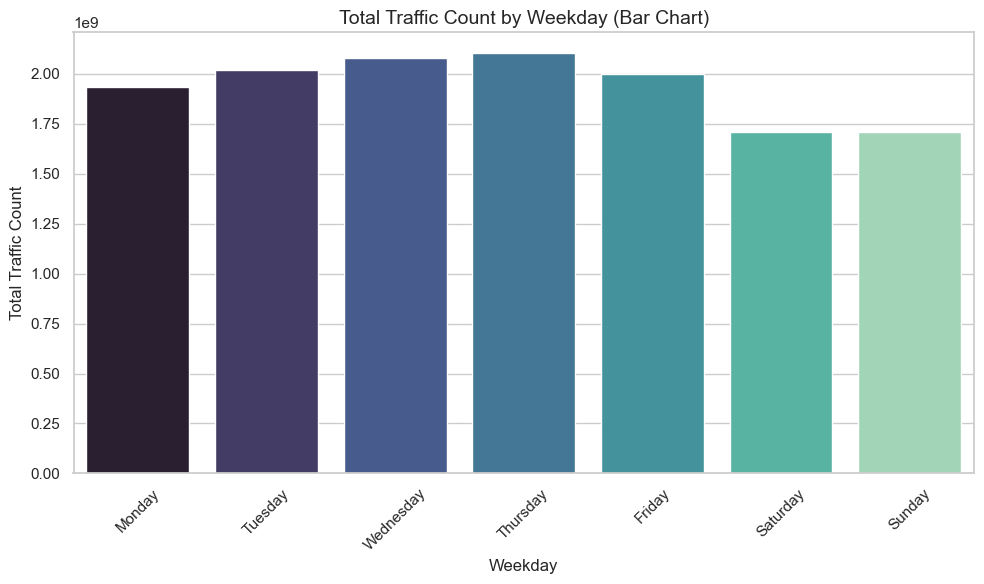

C:\Users\pc\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\pc\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


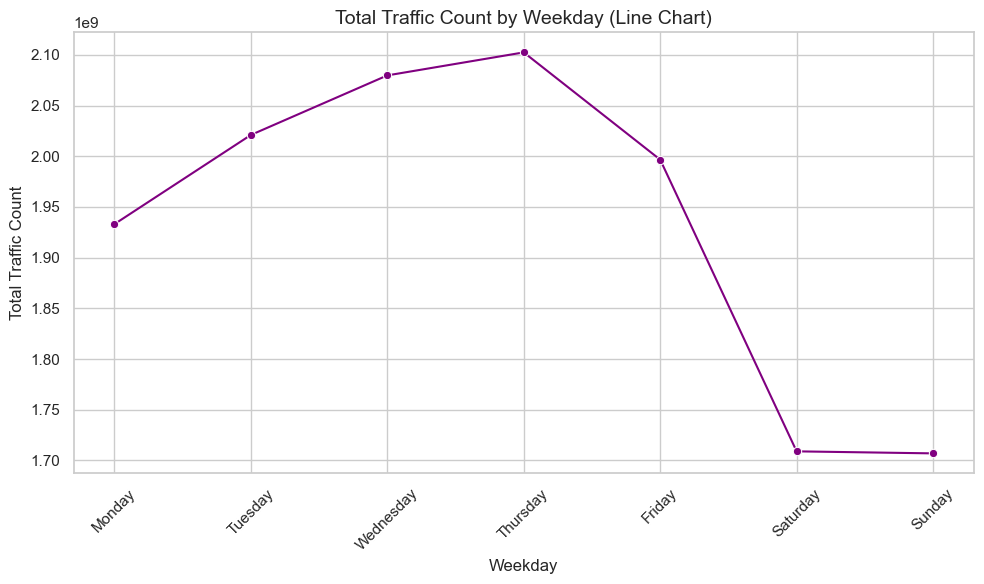

In [124]:
sns.set(style="whitegrid")

#Bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=weekday_summary, x='weekday', y='sum', palette='mako')
plt.title("Total Traffic Count by Weekday (Bar Chart)", fontsize=14)
plt.xlabel("Weekday", fontsize=12)
plt.ylabel("Total Traffic Count", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#line chart
plt.figure(figsize=(10, 6))
sns.lineplot(data=weekday_summary, x='weekday', y='sum', marker='o', color='purple')
plt.title("Total Traffic Count by Weekday (Line Chart)", fontsize=14)
plt.xlabel("Weekday", fontsize=12)
plt.ylabel("Total Traffic Count", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### **5-3. Which time zone is the most/least congested?**

**Traffic Count Distribution by Time Cluster(Hourly Peaks)**

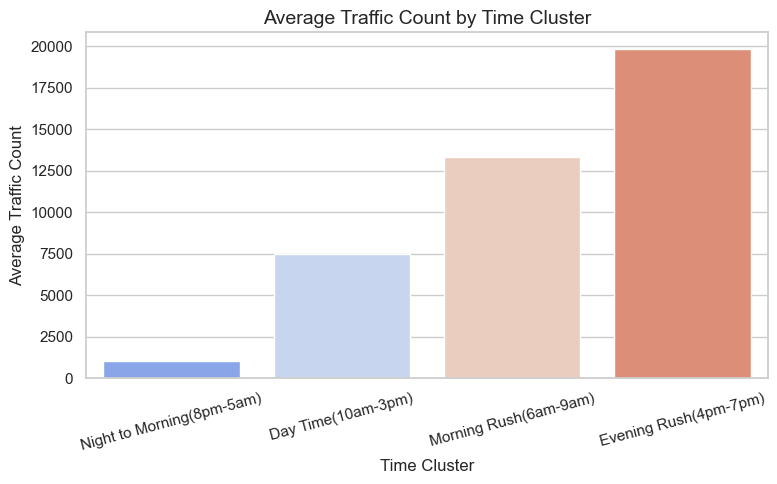

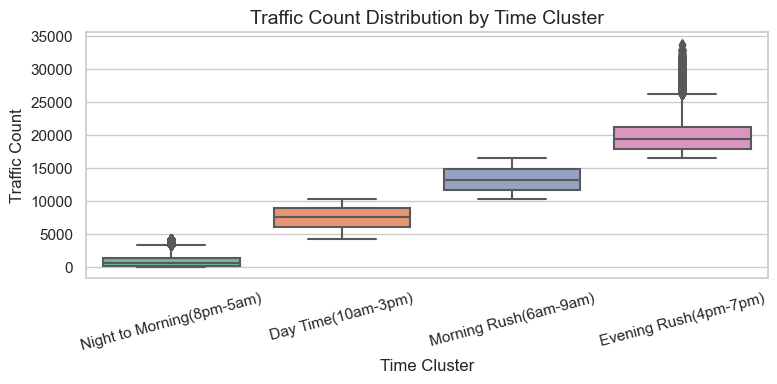

In [126]:
import matplotlib.pyplot as plt
import seaborn as sns
#Bar chart
plt.figure(figsize=(8, 5))
sns.barplot(data=akl_traffic1, x='time_label', y='Traffic Count', palette='coolwarm')

plt.title("Average Traffic Count by Time Cluster", fontsize=14)
plt.xlabel("Time Cluster", fontsize=12)
plt.ylabel("Average Traffic Count", fontsize=12)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

#Boxplot
plt.figure(figsize=(8,4))
sns.boxplot(data=akl_traffic1, x='time_label', y='Traffic Count', palette='Set2')

plt.title("Traffic Count Distribution by Time Cluster", fontsize=14)
plt.xlabel("Time Cluster", fontsize=12)
plt.ylabel("Traffic Count", fontsize=12)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

### **5-4. Weather Impact**
5-4-1. Relationship between Rainfall and Traffic Count (2024)

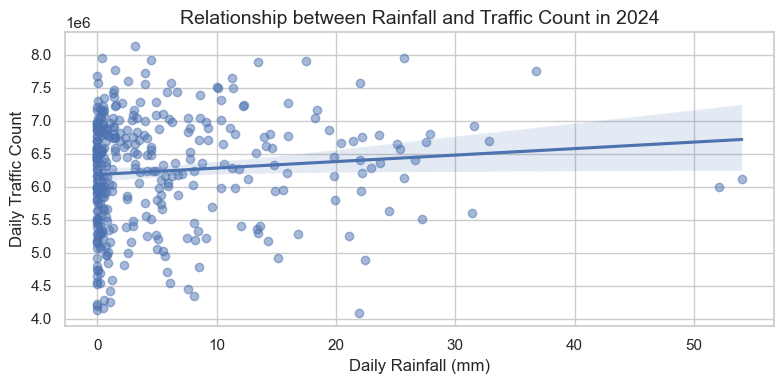

In [128]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,4))
sns.regplot(data=traffic_weather, x="rainfall_mm", y="Traffic Count", scatter_kws={"alpha":0.5})
plt.title("Relationship between Rainfall and Traffic Count in 2024", fontsize=14)
plt.xlabel("Daily Rainfall (mm)", fontsize=12)
plt.ylabel("Daily Traffic Count", fontsize=12)
plt.tight_layout()
plt.show()

Statistical Correlation Analysis

In [130]:
from scipy.stats import pearsonr

correlation, p_value = pearsonr(traffic_weather["rainfall_mm"], traffic_weather["Traffic Count"])

print(f"Correlation coefficient : {correlation:.3f}")
print(f"pvalue: {p_value:.5f}")

Correlation coefficient : 0.097
pvalue: 0.06504


*The data showed they Poorly correlated, then we conducted in-depth analysis below.*

5-4-2. Comparative Traffic Volume Analysis: Sunny vs. Rainy Days

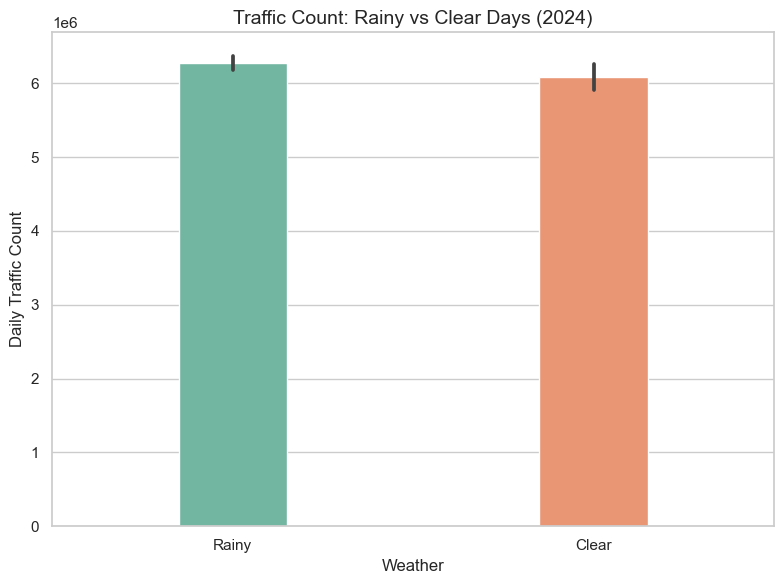

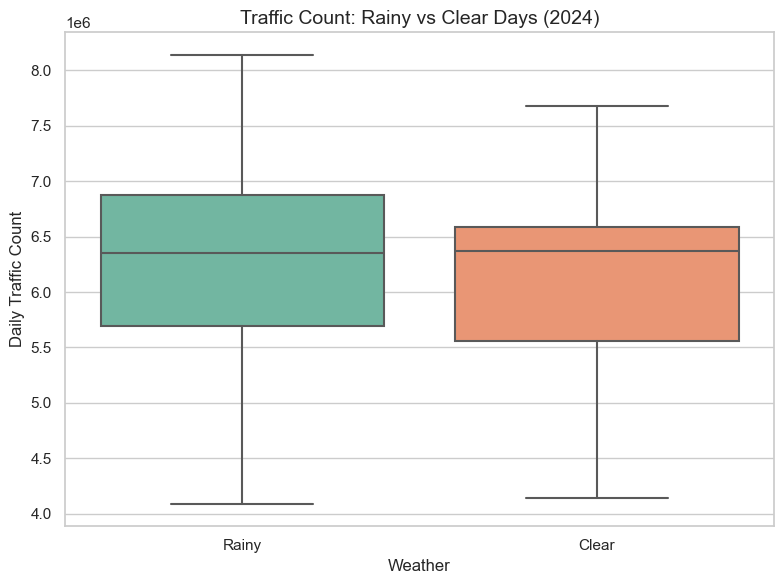

In [133]:
#Bar Chart
plt.figure(figsize=(8, 6))
sns.barplot(data=traffic_weather, x="weather", y="Traffic Count", palette="Set2",width=0.3)

plt.title("Traffic Count: Rainy vs Clear Days (2024)", fontsize=14)
plt.xlabel("Weather", fontsize=12)
plt.ylabel("Daily Traffic Count", fontsize=12)
plt.tight_layout()
plt.show()

#Box Plot
plt.figure(figsize=(8, 6))
sns.boxplot(data=traffic_weather, x="weather", y="Traffic Count", palette="Set2")

plt.title("Traffic Count: Rainy vs Clear Days (2024)", fontsize=14)
plt.xlabel("Weather", fontsize=12)
plt.ylabel("Daily Traffic Count", fontsize=12)
plt.tight_layout()
plt.show()

5-4-3. Traffic Volume Analysis by Rainfall Level (2024)

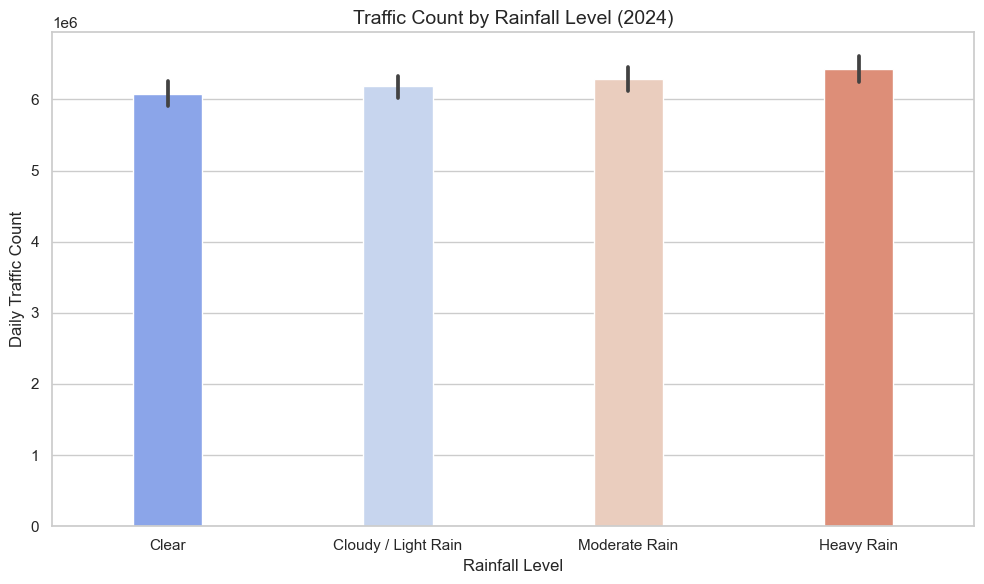

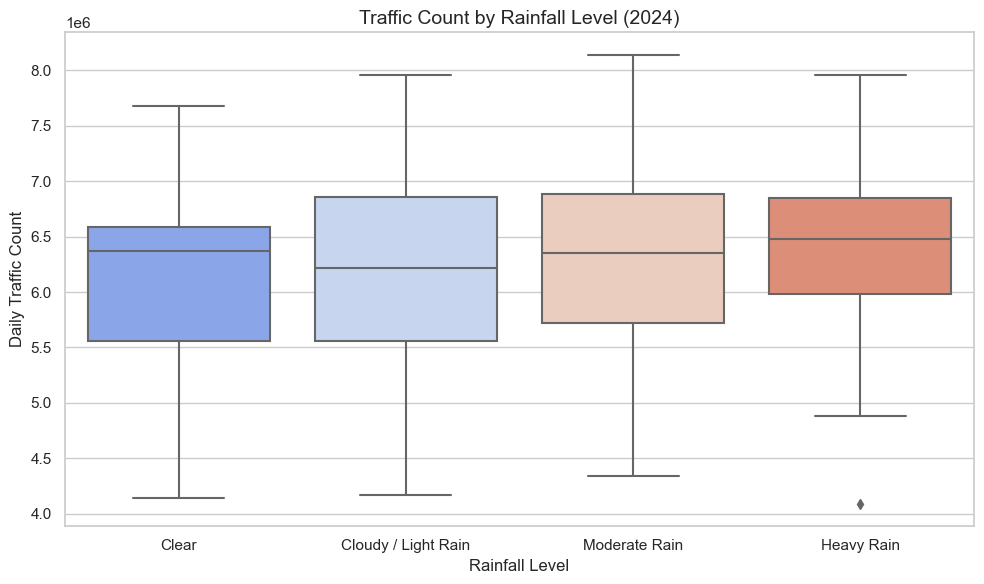

In [135]:
#Bar Chart
plt.figure(figsize=(10, 6))
sns.barplot(data=traffic_weather, x="rain_level", y="Traffic Count", palette="coolwarm",width=0.3,  order=["Clear", "Cloudy / Light Rain", "Moderate Rain", "Heavy Rain"])

plt.title("Traffic Count by Rainfall Level (2024)", fontsize=14)
plt.xlabel("Rainfall Level", fontsize=12)
plt.ylabel("Daily Traffic Count", fontsize=12)
plt.tight_layout()
plt.show()

#Box Plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=traffic_weather, x="rain_level", y="Traffic Count", palette="coolwarm", order=["Clear", "Cloudy / Light Rain", "Moderate Rain", "Heavy Rain"])

plt.title("Traffic Count by Rainfall Level (2024)", fontsize=14)
plt.xlabel("Rainfall Level", fontsize=12)
plt.ylabel("Daily Traffic Count", fontsize=12)
plt.tight_layout()
plt.show()

### **5-5. Which Road Segment is the most/least congested?**
**Routes recommendation**

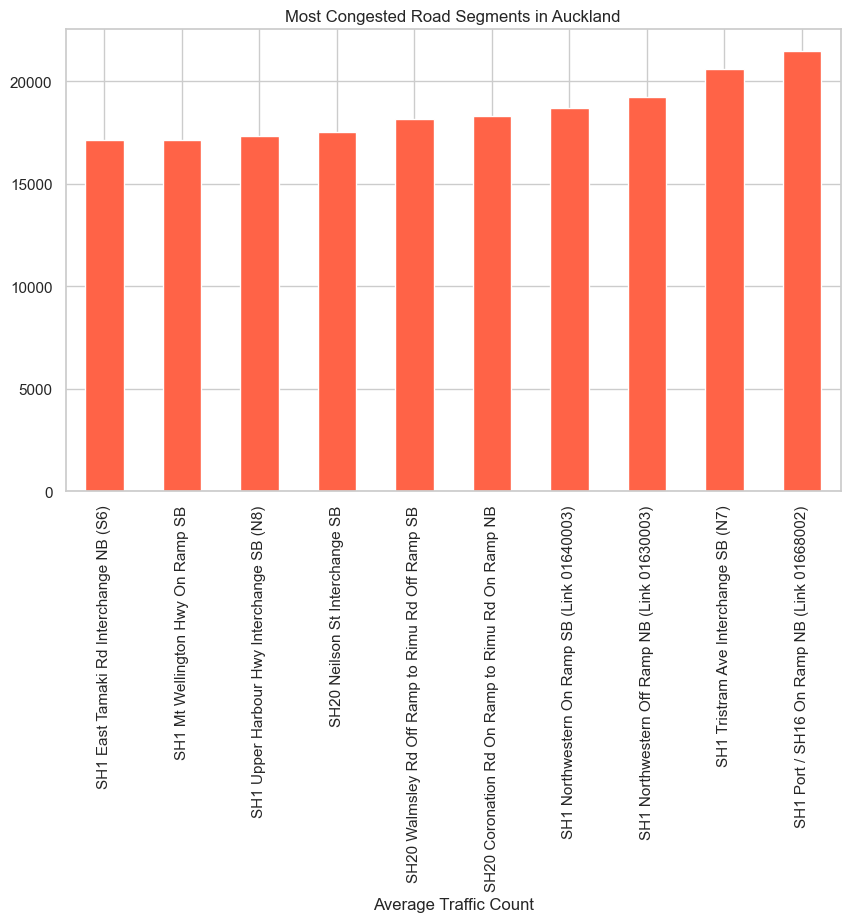

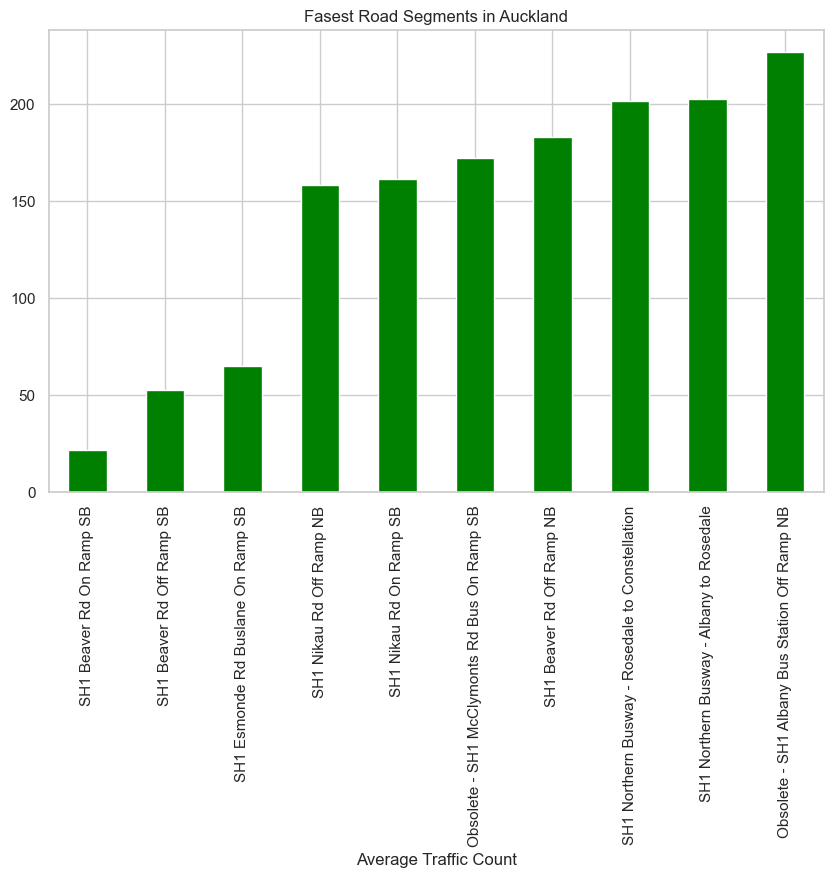

In [137]:
import matplotlib.pyplot as plt
top_10_congested = segment_load.tail(10)
bottom_10_calm = segment_load.head(10)

plt.figure(figsize=(10, 6))
top_10_congested.plot(kind='bar', color = 'tomato')
plt.title("Most Congested Road Segments in Auckland")
plt.xlabel("Average Traffic Count")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
bottom_10_calm.plot(kind='bar', color = 'green')
plt.title("Fasest Road Segments in Auckland")
plt.xlabel("Average Traffic Count")
plt.grid(True)
plt.show()

### **6. Modeling & Forecasting**

#### **6-1. Highest-probability date for peak traffic congestion events**

Using predictive modeling, we forecasted the highest-probability date for peak traffic congestion events.

12:04:58 - cmdstanpy - INFO - Chain [1] start processing
12:05:00 - cmdstanpy - INFO - Chain [1] done processing


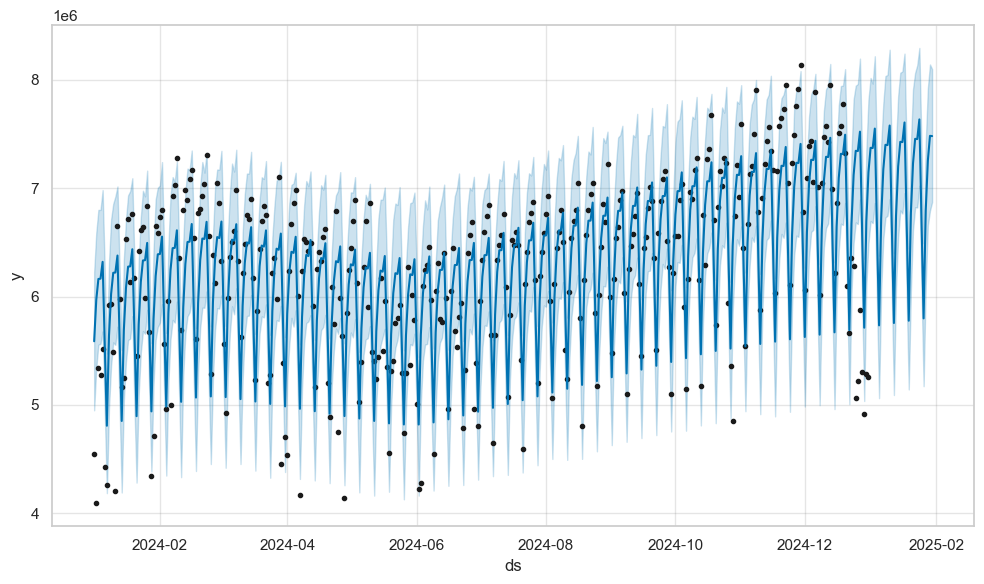

In [141]:
!pip install prophet
from prophet import Prophet
# Choose necessary data and change into formas Prophet wants
traffic_data = traffic_weather[['date', 'Traffic Count']]
traffic_data.columns= ['ds', 'y']

model = Prophet(seasonality_mode = 'multiplicative')
model.fit(traffic_data)
future = model.make_future_dataframe(periods = 30, freq='D')
forecast = model.predict(future)

model.plot(forecast);

**Predict a peak date**

In [143]:
peak = forecast.loc[forecast['yhat'].idxmax()]
print("Projected peak days:")
print(peak[["ds", "yhat"]])

Projected peak days:
ds      2025-01-24 00:00:00
yhat         7636054.991145
Name: 389, dtype: object


#### **6-2. Modeling Traffic Volume Fluctuations when it rains and does not.**

12:05:02 - cmdstanpy - INFO - Chain [1] start processing
12:05:02 - cmdstanpy - INFO - Chain [1] done processing
12:05:03 - cmdstanpy - INFO - Chain [1] start processing
12:05:03 - cmdstanpy - INFO - Chain [1] done processing


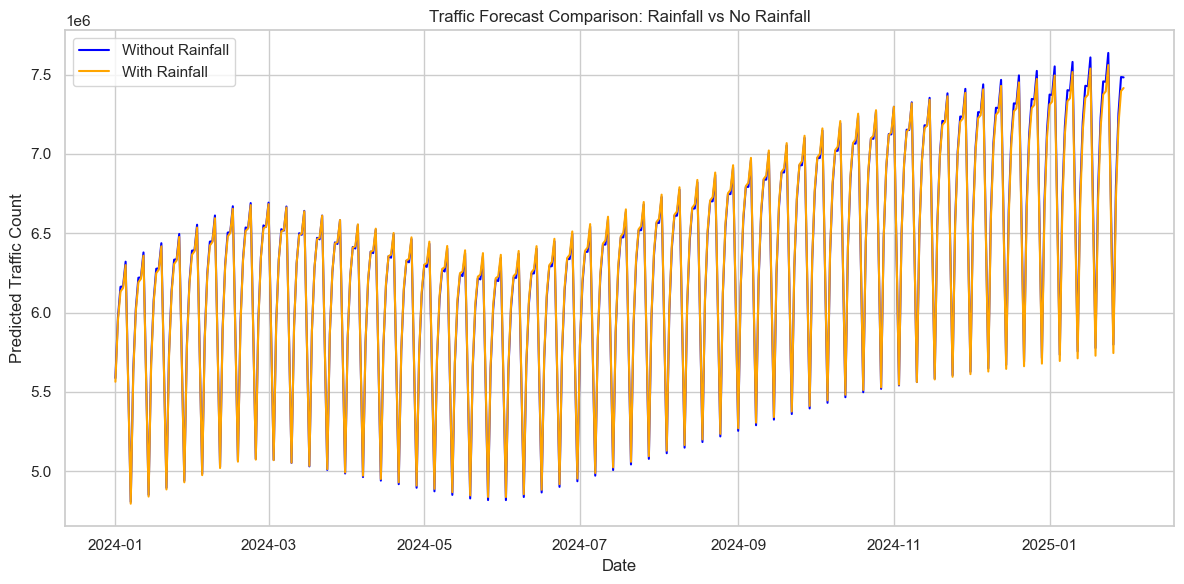

In [145]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt


df = traffic_weather.copy()
df['date'] = pd.to_datetime(df['date'])

#Model1 - Clear days(No Rain)
df1 = df[['date', 'Traffic Count']].rename(columns={'date': 'ds', 'Traffic Count': 'y'})
model1 = Prophet(seasonality_mode='multiplicative')
model1.fit(df1)
future1 = model1.make_future_dataframe(periods=30)  # 30日先まで予測
forecast1 = model1.predict(future1)


# Model2 - Rainy days
df2 = df[['date', 'Traffic Count', 'rainfall_mm']].rename(columns={'date': 'ds', 'Traffic Count': 'y'})
model2 = Prophet(seasonality_mode='multiplicative')
model2.add_regressor('rainfall_mm')
model2.fit(df2)
future2 = model2.make_future_dataframe(periods=30)
mean_rain = df2['rainfall_mm'].mean()
future2['rainfall_mm'] = mean_rain
forecast2 = model2.predict(future2)


# Clear days VS Rainy days
plt.figure(figsize=(12, 6))
plt.plot(forecast1['ds'], forecast1['yhat'], label='Without Rainfall', color='blue')
plt.plot(forecast2['ds'], forecast2['yhat'], label='With Rainfall', color='orange')
plt.xlabel('Date')
plt.ylabel('Predicted Traffic Count')
plt.title('Traffic Forecast Comparison: Rainfall vs No Rainfall')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### **7. Insights & Interpretation**

**7-1. Traffic Patterns by Time**

- Monthly trends revealed that April and August tend to have lower traffic volumes, likely due to school holidays,milder weather reducing discretionary travel, and lower tourism activity during these shoulder seasons, whereas February, July and November showed consistent congestion increases.

- Weekly analysis showed that  Thursdays is consistently high-congestion days, with weekends generally less congested.
- Time-of-day patterns clearly indicated morning (6–9 AM) and evening (4–7 PM) as peak congestion periods — typical commuter times.

**7-2. Weather’s Impact on Congestion**

- Clear days were associated with smoother traffic flows and slightly lower overall volume.
- Light rain or cloudy days still maintained higher traffic volume, suggesting minor weather doesn't deter travel, and heavy rainfall correlated with increased vehicle usage compared to other periods.
- Moderate rain didn't increase traffic count significantly but still correlated with increased congestion levels.
- Overall, precipitation events show no statistically significant impact on traffic congestion levels based on our analysis (From section 5-4 and 6-2).

**7-3. Route-Level Insights**

- The busiest traffic hotspot is the northbound ramp where State Highway 16 (Northwestern Motorway) merges onto State Highway 1 near the Port—especially during rush hours.
- The least busy on-ramps is the southbound entrance to SH1 Northern Motorway from Beaver Road in Albany.
- This suggests opportunity to promote alternative routes or staggered work hours for those commuting to high-density zones.

**7-4. Forecasted Congestion Peaks**

- Using Prophet modeling, the next predicted peak congestion date is 24.01.2025, with a forecasted volume of over 7636054 vehicles.
- This predictive data enables proactive resource allocation, including traffic signal optimization and public transport schedule adjustments (e.g., increased bus/train frequencies), in preparation for anticipated peak demand periods.

### **8. Interactive Dashboard**

**8-1.  Real-Time Congested Route Visualization – Streamlit Map Component**

*When you run streamlit run app.py, it opens a browser with:*
- A dashboard title and description
- A map of Auckland with congested route markers
- Fully interactive — you can pan, zoom, or hover over points

In [157]:
!pip install streamlit
import streamlit as st 
#To make maps
!pip install folium
import folium
#Title of the App
st.title("Auckland Live Traffic Optimizer")
st.write("Top Congested Route Today")
most_congested_route = pd.DataFrame({
    'latitude': [-36.8485, -36.8490, -36.8495],
    'longitude': [174.7633, 174.7640, 174.7650]
})
#Based on Longitude and Latitude, that makes a map
st.map(most_congested_route)

2025-05-03 12:05:52.346 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-03 12:05:53.552 
  command:

    streamlit run C:\Users\pc\anaconda3\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-05-03 12:05:53.552 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-03 12:05:53.552 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-03 12:05:53.552 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-03 12:05:53.552 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-03 12:05:53.552 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-03 12:05:53.572 Thread 'MainThread': missi

DeltaGenerator()

**8-2. Interactive Heatmap Dashboard – Auckland Traffic Congestion**

In [159]:
!pip install folium
!pip install streamlit
!pip install geopy
import folium
from folium.plugins import HeatMap
import pandas as pd

data = pd.DataFrame({
    'latitude': [-36.8485, -36.8490, -36.8495, -36.8500],
    'longitude': [174.7633, 174.7640, 174.7650, 174.7660],
    'traffic_count': [500, 1500, 3000, 4000]
})

m = folium.Map(location=[-36.8485, 174.7633], zoom_start=13)

heat_data = [[row['latitude'], row['longitude'], row['traffic_count']] for index, row in data.iterrows()]

HeatMap(heat_data).add_to(m)

m.save("auckland_traffic_heatmap.html")

In [160]:
#Ran this code to check if the heat map works.
import webbrowser
webbrowser.open("auckland_traffic_heatmap.html")

True

### **9. Conclusion & Recommendations**

#### **Conclusion:**

This project successfully analyzed Auckland's traffic congestion using historical vehicle count and weather data, revealing clear temporal, spatial, and environmental patterns. Monthly and daily traffic variations aligned closely with seasonal behaviors, public holidays, and commuter habits, while weather conditions—particularly heavy rain—were found to influence traffic volume and flow in nuanced ways. Spatial route analysis further identified critical congestion hotspots. Moreover, predictive modeling with Prophet enabled forecasting of the highest-impact congestion day, offering valuable foresight for infrastructure planning.

#### **Recommendations:**

**1. Target High-Impact Days with Dynamic Strategies:**

- Prepare for peak dates like 24 January 2025, using dynamic congestion mitigation such as adjusted traffic light cycles, incident response teams, and increased public transport services.

- Consider a "congestion alert system" for citizens on forecasted peak days.

**2. Incentivize Off-Peak Travel:**

- Encourage flexible work hours and remote work policies, especially on high-traffic Thursdays and peak morning/evening times (6–9 AM, 4–7 PM).

- Promote travel during shoulder seasons (April, August) for tourism and logistics.

**3. Route-Level Optimization:**

- Improve signage and public awareness to redirect drivers away from bottlenecks such as the SH16-to-SH1 northbound ramp.

- Consider minor upgrades or ramp metering at underused access points like Beaver Road in Albany to balance flow across the network.

**4. Weather-Responsive Planning:**

- While moderate rain has minimal effect on traffic count, severe weather preparation should still be prioritized, especially in emergency response and public transport planning.

- Use rainfall forecasts as indirect congestion indicators in real-time traffic management dashboards.

**5. Integrate with Real-Time Systems:**
- Consider deploying this analysis as an interactive dashboard (e.g., Streamlit + Folium) to support city planners and traffic managers in real-time decision-making.

- Enhance the model using live weather and congestion feeds to create a truly adaptive smart traffic system.

By combining temporal forecasting, spatial analysis, and environmental insights, this project demonstrates a data-driven foundation for a smarter, more efficient urban traffic strategy in Auckland. Future work can include integrating live GPS data, public transport metrics, and citizen mobility trends for even deeper impact.

*Thank you!*